# Student Performance Predictions

In this project we will analyze the student performance in a data set and we will predict the final grade between 0 and 100 of the students using a regression tree and random forest algorithm, taking into consideration factors such as:
- Hours of study
- Attendance
- Hours of sleep
- Type of school (private/public)
- Extracurricular activities

## Library imports

In [482]:
!pip install xgboost --quiet

In [483]:
import xgboost
print(xgboost.__version__)

3.0.2


In [488]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import chi2_contingency

In [490]:
df = pd.read_csv('StudentPerformanceFactors.csv')

In [492]:
df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


## Data Preparation

In [495]:
# Data Types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

In [497]:
# row number
df.shape[0]

6607

In [499]:
df.columns

Index(['Hours_Studied', 'Attendance', 'Parental_Involvement',
       'Access_to_Resources', 'Extracurricular_Activities', 'Sleep_Hours',
       'Previous_Scores', 'Motivation_Level', 'Internet_Access',
       'Tutoring_Sessions', 'Family_Income', 'Teacher_Quality', 'School_Type',
       'Peer_Influence', 'Physical_Activity', 'Learning_Disabilities',
       'Parental_Education_Level', 'Distance_from_Home', 'Gender',
       'Exam_Score'],
      dtype='object')

In [501]:
df.describe()

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score
count,6607.000000,6607.000000,6607.00000,6607.000000,6607.000000,6607.000000,6607.000000
mean,19.975329,79.977448,7.02906,75.070531,1.493719,2.967610,67.235659
std,5.990594,11.547475,1.46812,14.399784,1.230570,1.031231,3.890456
min,1.000000,60.000000,4.00000,50.000000,0.000000,0.000000,55.000000
25%,16.000000,70.000000,6.00000,63.000000,1.000000,2.000000,65.000000
50%,20.000000,80.000000,7.00000,75.000000,1.000000,3.000000,67.000000
75%,24.000000,90.000000,8.00000,88.000000,2.000000,4.000000,69.000000
max,44.000000,100.000000,10.00000,100.000000,8.000000,6.000000,101.000000


In [503]:
# NaN values
df.isnull().sum()

Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               78
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      90
Distance_from_Home            67
Gender                         0
Exam_Score                     0
dtype: int64

In [505]:
# Unique values of NaN variables
print('Teacher_Quality: ', df['Teacher_Quality'].unique())
print('Parental_Education_Level: ', df['Parental_Education_Level'].unique())
print('Distance_from_Home: ', df['Distance_from_Home'].unique())

Teacher_Quality:  ['Medium' 'High' 'Low' nan]
Parental_Education_Level:  ['High School' 'College' 'Postgraduate' nan]
Distance_from_Home:  ['Near' 'Moderate' 'Far' nan]


In [507]:
# Highest frequency value
f_Teacher_Quality = df['Teacher_Quality'].value_counts().idxmax()
f_Parental_Education_Level = df['Parental_Education_Level'].value_counts().idxmax()
f_Distance_from_Home = df['Distance_from_Home'].value_counts().idxmax()

# Replace NaN with the highest frequency value
df['Teacher_Quality'] = df['Teacher_Quality'].fillna(f_Teacher_Quality)
df['Parental_Education_Level'] = df['Parental_Education_Level'].fillna(f_Parental_Education_Level)
df['Distance_from_Home'] = df['Distance_from_Home'].fillna(f_Distance_from_Home)

In [509]:
# NaN value count
print('Teacher_Quality NaN values: ',df['Teacher_Quality'].isnull().sum())
print('Parental_Education_Level NaN values: ',df['Parental_Education_Level'].isnull().sum())
print('Distance_from_Home NaN values: ',df['Distance_from_Home'].isnull().sum())

Teacher_Quality NaN values:  0
Parental_Education_Level NaN values:  0
Distance_from_Home NaN values:  0


In [511]:
df.columns

Index(['Hours_Studied', 'Attendance', 'Parental_Involvement',
       'Access_to_Resources', 'Extracurricular_Activities', 'Sleep_Hours',
       'Previous_Scores', 'Motivation_Level', 'Internet_Access',
       'Tutoring_Sessions', 'Family_Income', 'Teacher_Quality', 'School_Type',
       'Peer_Influence', 'Physical_Activity', 'Learning_Disabilities',
       'Parental_Education_Level', 'Distance_from_Home', 'Gender',
       'Exam_Score'],
      dtype='object')

## Exploratory Data Analysis (EDA)

We want to find out what factors impact students' grade averages

In [515]:
# Minimum, maximum and average scores of students by gender
df_female = df[df['Gender'] == 'Female']
df_male = df[df['Gender'] == 'Male']

df_scores = {'Gender': ['Female', 'Male'],
            'Min Exam Score:': [df[df['Gender'] == 'Female']['Exam_Score'].min(), df_male['Exam_Score'].min()],
            'Max Exam Score': [df_female['Exam_Score'].max(), df_male['Exam_Score'].max()],
            'Avg Exam Score': [df_female['Exam_Score'].mean(), df_male['Exam_Score'].mean()]}

df_gender_scores = pd.DataFrame(df_scores)
df_gender_scores

,Gender,Min Exam Score:,Max Exam Score,Avg Exam Score
0,Female,57,101,67.244898
1,Male,55,99,67.228894


Text(0.5, 1.0, 'Students Scores Average')

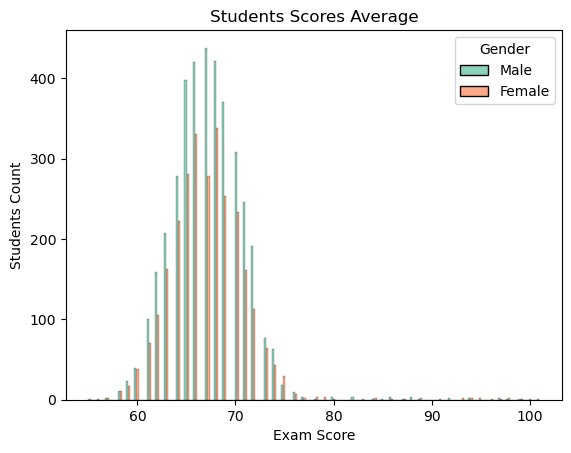

In [517]:
sns.histplot(data = df, x = 'Exam_Score', hue = 'Gender', palette = 'Set2', multiple='dodge')
plt.ylabel('Students Count')
plt.xlabel('Exam Score')
plt.title('Students Scores Average')

In [519]:
# Correlation of numerical variables vs Exam_Score
df_numeric = df.select_dtypes(include = ['number'])
df_num_corr = df_numeric.corr()['Exam_Score'].sort_values(ascending = False)
print(df_num_corr)

Exam_Score           1.000000
Attendance           0.581072
Hours_Studied        0.445455
Previous_Scores      0.175079
Tutoring_Sessions    0.156525
Physical_Activity    0.027824
Sleep_Hours         -0.017022
Name: Exam_Score, dtype: float64


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0.5, 0, 'Hours_Studied'),
  Text(1.5, 0, 'Attendance'),
  Text(2.5, 0, 'Sleep_Hours'),
  Text(3.5, 0, 'Previous_Scores'),
  Text(4.5, 0, 'Tutoring_Sessions'),
  Text(5.5, 0, 'Physical_Activity'),
  Text(6.5, 0, 'Exam_Score')])

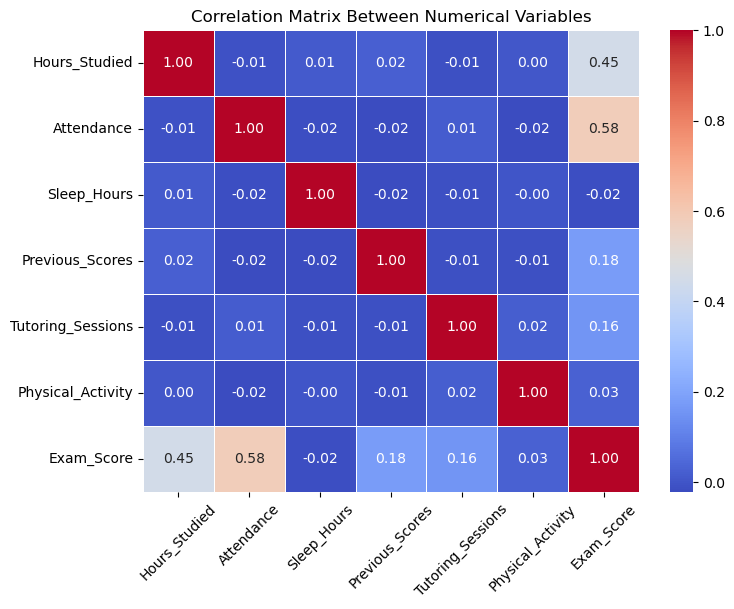

In [521]:
# Correlation matrix
corr_matrix = df_numeric.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f', linewidths=0.5)
plt.title('Correlation Matrix Between Numerical Variables')
plt.xticks(rotation=45)

In [523]:
# binning of the average number of students into low, medium and high
performance = ['Low','Medium','High']
score_bins = np.linspace(min(df['Exam_Score']), max(df['Exam_Score']), num=4)
df['Exam_Score_Binned'] = pd.cut(df['Exam_Score'], score_bins, labels = performance, include_lowest = True)

# binning of the students sleep hours
df['Sleep_Hours_Binned'] = pd.cut(df['Sleep_Hours'], bins = [4,5,6,7,8,9,10], labels = ['4–5', '5–6', '6–7', '7–8', '8–9', '9–10'])

Text(0.5, 1.0, 'Sleep Hours vs Exam Score')

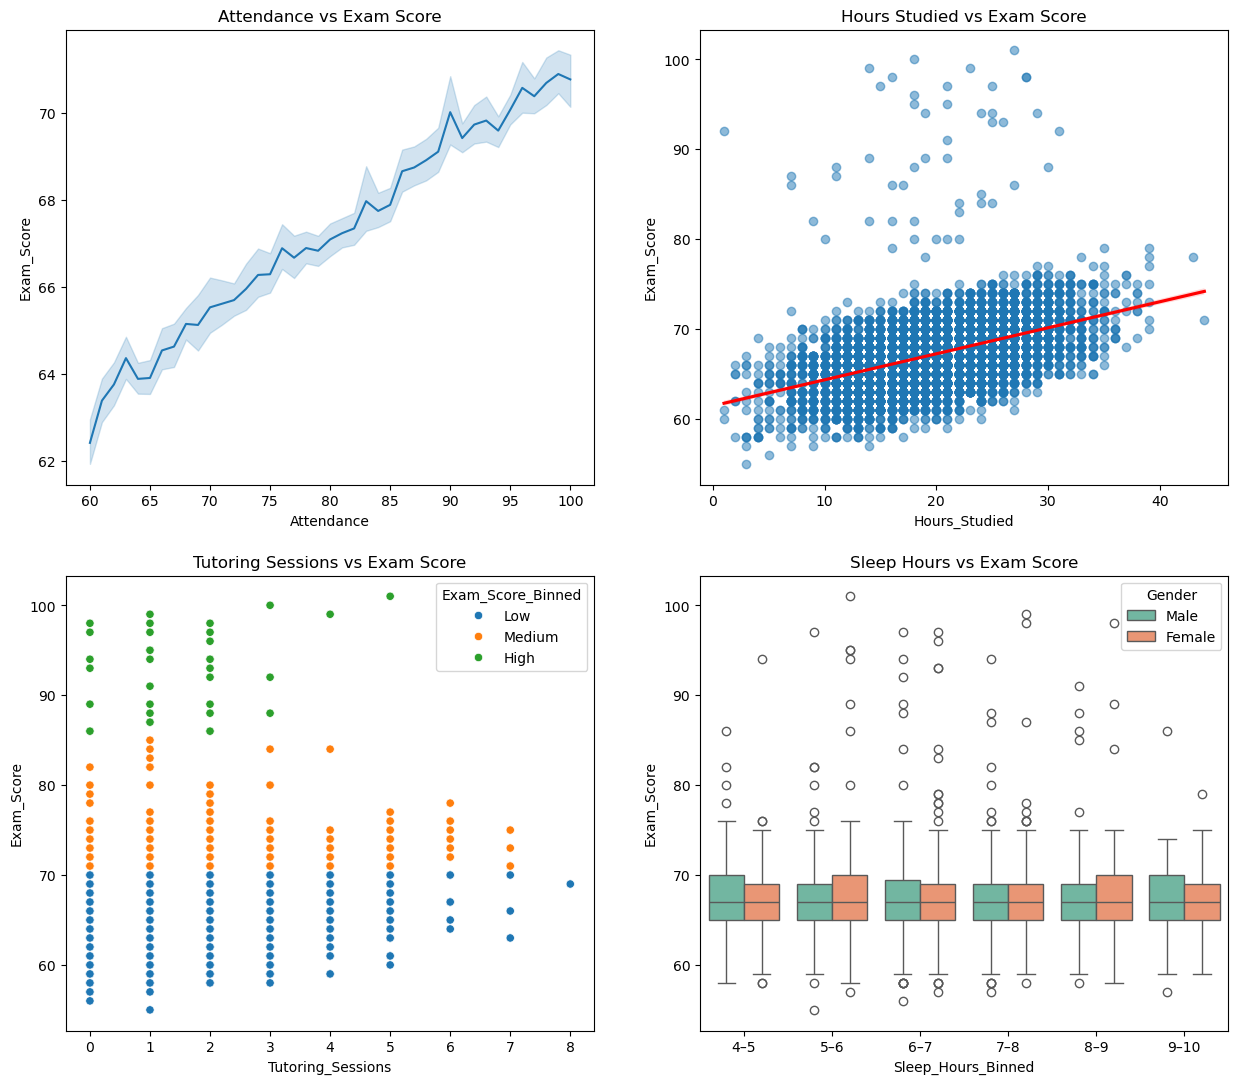

In [525]:
fig, axes = plt.subplots(2, 2, figsize=(15, 13))
axes = axes.flatten()

sns.lineplot(data = df, x='Attendance', y='Exam_Score', ax=axes[0])
axes[0].set_title('Attendance vs Exam Score')

sns.regplot(data = df, x='Hours_Studied', y='Exam_Score', line_kws={'color': 'red'},  scatter_kws={'alpha': 0.5},  ax=axes[1])
axes[1].set_title('Hours Studied vs Exam Score')

sns.scatterplot(data = df, x='Tutoring_Sessions', y='Exam_Score', hue='Exam_Score_Binned', ax=axes[2])
axes[2].set_title('Tutoring Sessions vs Exam Score')

sns.boxplot(data = df, x='Sleep_Hours_Binned', y='Exam_Score', hue = df['Gender'] ,palette = 'Set2', ax=axes[3])
axes[3].set_title('Sleep Hours vs Exam Score')

## Model Development

### <font color = blue> Regression Tree </font>

In [529]:
# Data Preparation
X_num = df.select_dtypes(include = ['number'])
X_num = X_num.drop(['Exam_Score'], axis = 1)

X = X_num               # Independent variable
y = df['Exam_Score']    # Dependent variable

# Data division, training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model construction
rt_model = DecisionTreeRegressor(criterion = 'squared_error', max_depth = 8, random_state = 42)

# Model training
rt_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, random_state=42)

#### Model Evaluation

In [532]:
rt_y_pred = rt_model.predict(X_test)

rt_mse_score = mean_squared_error(y_test, rt_y_pred)
rt_r2_score = rt_model.score(X_test,y_test)

print('MSE score : {0:.3f}'.format(rt_mse_score))
print('R^2 score : {0:.3f}'.format(rt_r2_score))  

MSE score : 9.817
R^2 score : 0.286


#### Model Fitting

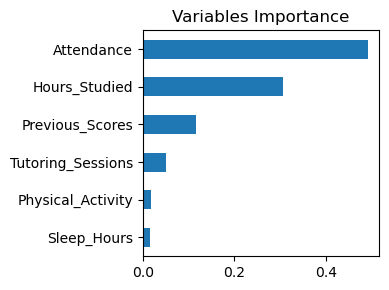

In [535]:
importances = pd.Series(rt_model.feature_importances_, index = X.columns)
importances.sort_values(ascending = True).plot(kind = 'barh', figsize = (4, 3), title = "Variables Importance")
plt.tight_layout()
plt.show()

In [537]:
# Selection of only the three variables with the highest correlation with Exam_Score
top3_corr = df.select_dtypes(include = ['number']).corr()['Exam_Score'].drop('Exam_Score')
abs(top3_corr).sort_values(ascending=False)[:3]

Attendance         0.581072
Hours_Studied      0.445455
Previous_Scores    0.175079
Name: Exam_Score, dtype: float64

In [539]:
top3_corr = df[['Attendance', 'Hours_Studied', 'Previous_Scores']]

In [541]:
# Data Preparation
X = top3_corr           # Independent variable
y = df['Exam_Score']    # Dependent variable

# Data division, training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model construction
rt_model = DecisionTreeRegressor(criterion = 'squared_error', max_depth = 8, random_state = 42)

# Model training
rt_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, random_state=42)

#### Model Evaluation

In [544]:
rt_y_pred = rt_model.predict(X_test)

rt_mse_score = mean_squared_error(y_test, rt_y_pred)
rt_rmse = np.sqrt(rt_mse_score)
rt_r2_score = rt_model.score(X_test,y_test)

print('MSE score : {0:.3f}'.format(rt_mse_score))
print('RMSE score : {0:.3f}'.format(rt_rmse))
print('R^2 score : {0:.3f}'.format(rt_r2_score))  

MSE score : 7.441
RMSE score : 2.728
R^2 score : 0.458


### <font color = blue> Random Forest Regressor </font>

In [547]:
# Data Preparation
X = df.select_dtypes(include = ['number']).drop(['Exam_Score'], axis = 1)
y = df['Exam_Score']

# Data division, training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model construction
rf_model = RandomForestRegressor(n_estimators = 100, max_depth = 10, random_state = 42)

# Model training
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=42)

#### Model Evaluation

In [550]:
rf_y_pred = rf_model.predict(X_test)

rf_mse_score = mean_squared_error(y_test, rf_y_pred)
rf_rmse = np.sqrt(rf_mse_score)
rf_r2_score = rf_model.score(X_test,y_test)

print('MSE score : {0:.3f}'.format(rf_mse_score))
print('RMSE score : {0:.3f}'.format(rf_rmse))
print('R^2 score : {0:.3f}'.format(rf_r2_score))

MSE score : 6.047
RMSE score : 2.459
R^2 score : 0.560


### <font color = blue> XGBoost </font>

In [553]:
# Data Preparation
X = df.select_dtypes(include = ['number']).drop(['Exam_Score'], axis = 1)
y = df['Exam_Score']

# Data division, training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model construction
xgb_model = XGBRegressor(n_estimators = 200, learning_rate = 0.05, max_depth = 4, min_child_weight=3, subsample=0.8, 
                         colsample_bytree=0.8, random_state = 42, objective='reg:squarederror')

# Model training
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

#### Model Evaluation

In [556]:
xgb_y_predict = xgb_model.predict(X_test)

xgb_mse_score = mean_squared_error(y_test, xgb_y_predict)
xgb_rmse = np.sqrt(xgb_mse_score)
xgb_r2_score = xgb_model.score(X_test,y_test)

print('MSE score : {0:.3f}'.format(xgb_mse_score))
print('RMSE score : {0:.3f}'.format(xgb_rmse))
print('R^2 score : {0:.3f}'.format(xgb_r2_score))

MSE score : 5.139
RMSE score : 2.267
R^2 score : 0.626


#### Model Fitting

To optimize the XGBoost model and attempt to improve the coefficient of determination (R²) and the mean squared error (MSE), we will convert the categorical variables in the DataFrame using LabelEncoder and fit them to the model.

In [560]:
# Library import
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [562]:
df_new = df
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Hours_Studied               6607 non-null   int64   
 1   Attendance                  6607 non-null   int64   
 2   Parental_Involvement        6607 non-null   object  
 3   Access_to_Resources         6607 non-null   object  
 4   Extracurricular_Activities  6607 non-null   object  
 5   Sleep_Hours                 6607 non-null   int64   
 6   Previous_Scores             6607 non-null   int64   
 7   Motivation_Level            6607 non-null   object  
 8   Internet_Access             6607 non-null   object  
 9   Tutoring_Sessions           6607 non-null   int64   
 10  Family_Income               6607 non-null   object  
 11  Teacher_Quality             6607 non-null   object  
 12  School_Type                 6607 non-null   object  
 13  Peer_Influence    

In [564]:
categorical_columns = [
    'Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities','Motivation_Level','Internet_Access', 
    'Family_Income', 'Teacher_Quality','School_Type', 'Peer_Influence', 'Learning_Disabilities','Parental_Education_Level', 
    'Distance_from_Home', 'Gender'
]

for col in categorical_columns:
    df_new[col] = label_encoder.fit_transform(df_new[col])

In [566]:
df_new.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,...,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score,Exam_Score_Binned,Sleep_Hours_Binned
0,23,84,1,0,0,7,73,1,1,0,...,1,2,3,0,1,2,1,67,Low,6–7
1,19,64,1,2,0,8,59,1,1,2,...,1,0,4,0,0,1,0,61,Low,7–8
2,24,98,2,2,1,7,91,2,1,2,...,1,1,4,0,2,2,1,74,Medium,6–7
3,29,89,1,2,1,8,98,2,1,1,...,1,0,4,0,1,1,1,71,Medium,7–8
4,19,92,2,2,1,6,65,2,1,3,...,1,1,4,0,0,2,0,70,Low,5–6


In [574]:
# Correlation
df_new.corr(numeric_only = True)['Exam_Score'].sort_values(ascending = False)

Exam_Score                    1.000000
Attendance                    0.581072
Hours_Studied                 0.445455
Previous_Scores               0.175079
Tutoring_Sessions             0.156525
Peer_Influence                0.100217
Distance_from_Home            0.088934
Extracurricular_Activities    0.064382
Internet_Access               0.051475
Parental_Education_Level      0.044574
Physical_Activity             0.027824
Gender                       -0.002032
School_Type                  -0.008844
Motivation_Level             -0.014910
Sleep_Hours                  -0.017022
Family_Income                -0.026484
Teacher_Quality              -0.060824
Learning_Disabilities        -0.085066
Access_to_Resources          -0.090503
Parental_Involvement         -0.094289
Name: Exam_Score, dtype: float64

In [582]:
# Data Preparation
X = df_new.drop(['Exam_Score','Exam_Score_Binned','Sleep_Hours_Binned'], axis = 1)
y = df_new['Exam_Score']

# Data division, training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model construction
xgb_model = XGBRegressor(n_estimators = 200, learning_rate = 0.05, max_depth = 4, min_child_weight=3, subsample=0.8, 
                         colsample_bytree=0.8, random_state = 42, objective='reg:squarederror')

# Model training
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [584]:
xgb_y_predict = xgb_model.predict(X_test)

xgb_mse_score_fit = mean_squared_error(y_test, xgb_y_predict)
xgb_rmse_fit = np.sqrt(xgb_mse_score_fit)
xgb_r2_score_fit = xgb_model.score(X_test,y_test)

print('MSE score : {0:.3f}'.format(xgb_mse_score_fit))
print('RMSE score : {0:.3f}'.format(xgb_rmse_fit))
print('R^2 score : {0:.3f}'.format(xgb_r2_score_fit))

MSE score : 3.553
RMSE score : 1.885
R^2 score : 0.741


## Results

In [587]:
results = {'ML Model' : ['Regression Tree','Random Forest','XGBoost', 'XGBoost Fitted'],
           'R² Score' : [rt_r2_score, rf_r2_score, xgb_r2_score, xgb_r2_score_fit],
           'MSE Score' : [rt_mse_score, rf_mse_score, xgb_mse_score, xgb_mse_score_fit],
           'RMSE Score' : [rt_rmse, rf_rmse, xgb_rmse, xgb_rmse_fit],
          }
results = pd.DataFrame(results)
results

,ML Model,R² Score,MSE Score,RMSE Score
0,Regression Tree,0.458420,7.441290,2.727873
1,Random Forest,0.559881,6.047228,2.459111
2,XGBoost,0.626002,5.138719,2.266874
3,XGBoost Fitted,0.741389,3.553312,1.885023


## Conclusion

We can observe that the XGBoost model achieves the highest accuracy, with a coefficient of determination (R²) of 61.6%. After converting the categorical variables to numerical format, the model explains 74.1% of the variance in the data relationships.

The Root Mean Squared Error (RMSE) indicates that, on average, the model's predictions deviate by approximately 1.89 units, which is a reasonably acceptable value considering that the target variable's range is from 0 to 100.